In [ ]:
# ruff: noqa

"""
Gradient Ascent Pulse Engineering (GRAPE)
"""

import jax
import jax.numpy as jnp
import optax
from utils.gates import cnot
from utils.operators import identity, sigmax, sigmay, sigmaz
from utils.tensor import tensor

# TODO: Implement this with Pavlo's Cavity + Qubit coupled in dispersive regime


# for unitary evolution (not using density operator)
def optimize_pulse(
    H_drift,
    H_control,
    rho_0,
    C_target,
    num_t_slots,
    total_evo_time,
    max_iter=1000,
    convergence_threshold=1e-6,
    learning_rate=0.01,
):
    """
    Uses GRAPE to optimize a pulse.
    Args:
        H_drift: Drift Hamiltonian.
        H_control: List of Control Hamiltonians.
        rho_0: Initial density operator.
        C_target: Target operator.
        num_t_slots: Number of time slots.
        total_evo_time: Total evolution time.
        max_iter: Maximum number of iterations.
        convergence_threshold: Convergence threshold for fidelity change.
        learning_rate: Learning rate for gradient ascent.
    Returns:
        result: Dictionary containing optimized pulse and convergence data.
    """
    # Step 1: Initialize control amplitudes
    control_amplitudes = init_control_amplitudes(num_t_slots, len(H_control))
    delta_t = total_evo_time / num_t_slots

    # Convert H_control to array for easier manipulation
    H_control_array = jnp.array(H_control)

    def fidelity(control_amplitudes):
        propagators = compute_propagators(
            H_drift, H_control_array, delta_t, control_amplitudes
        )
        U_final = compute_forward_evolution(
            propagators, rho_0
        )  # rho_0 is U_0 here
        overlap = (
            jnp.trace(jnp.matmul(C_target.conj().T, U_final))
            / C_target.shape[0]
        )
        return (
            jnp.abs(overlap) ** 2
        )  # Fidelity = |Tr(U_target† U_final) / dim|^2

    # Step 2: Gradient ascent loop
    control_amplitudes, fidelities, iter_idx = optimize(
        fidelity,
        control_amplitudes,
        max_iter,
        learning_rate,
        convergence_threshold,
    )

    propagators = compute_propagators(
        H_drift, H_control_array, delta_t, control_amplitudes
    )
    rho_final = compute_forward_evolution(propagators, rho_0)

    return {
        "control_amplitudes": control_amplitudes,
        "final_fidelity": fidelities[-1],
        "fidelity_history": jnp.array(fidelities),
        "iterations": iter_idx + 1,
        "final_density_operator": rho_final,
    }


def compute_propagators(H_drift, H_control_array, delta_t, control_amplitudes):
    """
    Compute propagators for each time step according to Equation (4).
    Args:
        H_drift: Drift Hamiltonian.
        H_control_array: Array of control Hamiltonians.
        delta_t: Time step for evolution.
        control_amplitudes: Control amplitudes for each time slot.
    Returns:
        propagators: Array of propagators for each time step.
    """
    num_t_slots = control_amplitudes.shape[0]

    # Compute each Uj according to Equation (4)
    def compute_propagator_j(j):
        # Calculate total Hamiltonian for time step j
        H_0 = H_drift
        H_control = 0
        for k in range(len(H_control_array)):
            # print(f"Control Hamiltonian \n {H_control_array[k].real}")
            H_control += control_amplitudes[j, k] * H_control_array[k]

        H_total = H_0 + H_control
        # Compute propagator using matrix exponential (Equation 4)
        U_j = jax.scipy.linalg.expm(-1j * delta_t * H_total)
        return U_j

    # Create an array of propagators
    propagators = jax.vmap(compute_propagator_j)(jnp.arange(num_t_slots))
    return propagators


def compute_forward_evolution(propagators, U_0):
    """
    Compute the forward evolution states (ρⱼ) according to the paper's definition.
    ρⱼ = Uⱼ···U₁ρ₀U₁†···Uⱼ†

    Args:
        propagators: List of propagators for each time step.
        rho_0: Initial density operator.
    Returns:
        rho_j: List of density operators for each time step j.
    """

    U_final = U_0
    for U_j in propagators:
        # Forward evolution
        # rho_final = U_j @ rho_final @ U_j.conj().T
        U_final = U_j @ U_final

    return U_final


def init_control_amplitudes(num_t_slots, num_controls):
    """
    Initialize control amplitudes for the optimization process.
    Args:
        num_t_slots: Number of time slots.
        num_controls: Number of control Hamiltonians.
    Returns:
        init_control_amplitudes: Initialized control amplitudes.
    """
    # Random initialization
    # You can also initialize with zeros
    key = jax.random.PRNGKey(42)
    return jax.random.uniform(
        key,
        (num_t_slots, num_controls),
        minval=-(2 * jnp.pi * 0.05),
        maxval=(2 * jnp.pi * 0.05),
    )


def optimize(
    fidelity,
    control_amplitudes,
    max_iter,
    learning_rate,
    convergence_threshold,
):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(control_amplitudes)
    fidelities = []

    @jax.jit
    def step(params, state):
        loss = -fidelity(params)  # Minimize -fidelity
        grads = jax.grad(lambda x: -fidelity(x))(params)
        updates, new_state = optimizer.update(grads, state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_state, -loss

    params = control_amplitudes
    for iter_idx in range(max_iter):
        params, opt_state, current_fidelity = step(params, opt_state)
        fidelities.append(current_fidelity)

        if (
            iter_idx > 0
            and abs(fidelities[-1] - fidelities[-2]) < convergence_threshold
        ):
            print(f"Converged after {iter_idx} iterations.")
            break

        if iter_idx % 10 == 0:
            print(f"Iteration {iter_idx}, Fidelity: {current_fidelity}")

    return params, fidelities, iter_idx


if __name__ == "__main__":
    # Example usage
    g = 0  # Small coupling strength
    H_drift = g * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))
    H_ctrl = [
        tensor(sigmax(), identity(2)),
        tensor(sigmay(), identity(2)),
        tensor(sigmaz(), identity(2)),
        tensor(identity(2), sigmax()),
        tensor(identity(2), sigmay()),
        tensor(identity(2), sigmaz()),
        tensor(sigmax(), sigmax()),
        tensor(sigmay(), sigmay()),
        tensor(sigmaz(), sigmaz()),
    ]

    U_0 = identity(4)
    # Target operator (CNOT gate)
    C_target = cnot()

    num_t_slots = 500
    total_evo_time = 2 * jnp.pi

    # Run optimization
    result = optimize_pulse(
        H_drift,
        H_ctrl,
        U_0,
        C_target,
        num_t_slots,
        total_evo_time,
        max_iter=500,
        learning_rate=1e-2,
    )
    print("final_fidelity: ", result["final_fidelity"])
    print("U_f \n", result["final_density_operator"])

Iteration 0, Fidelity: 0.24571669101715088
Iteration 10, Fidelity: 0.5080397725105286
Iteration 20, Fidelity: 0.7743695974349976
Iteration 30, Fidelity: 0.9832098484039307
Iteration 40, Fidelity: 0.9732639193534851
Iteration 50, Fidelity: 0.9926656484603882
Iteration 60, Fidelity: 0.9985721707344055
Iteration 70, Fidelity: 0.9985859394073486
Iteration 80, Fidelity: 0.9996513724327087
Iteration 90, Fidelity: 0.9999501705169678
Converged after 97 iterations.
final_fidelity:  0.9999225
U_f 
 [[ 0.7097188 +0.7044263j   0.00380857-0.0009041j   0.00590039+0.00465511j
  -0.00297565-0.00184669j]
 [ 0.00088264-0.00378661j  0.70532745+0.70885384j  0.00265817-0.00399213j
   0.00124771-0.00176748j]
 [ 0.00186473+0.00293069j  0.00180379-0.00123342j -0.00125029+0.00454929j
   0.7071107 +0.7070744j ]
 [-0.0047038 -0.00589586j  0.00397366-0.00262903j  0.70616895+0.7079719j
  -0.00453741+0.00125449j]]


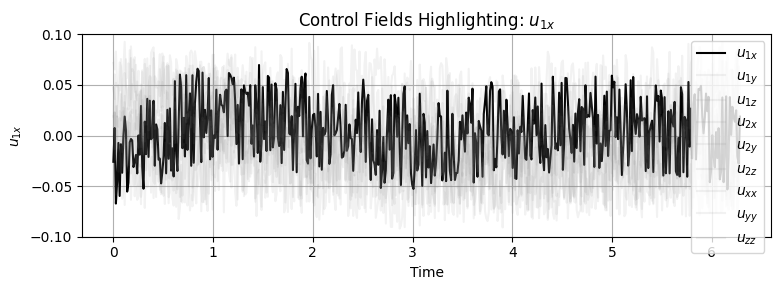

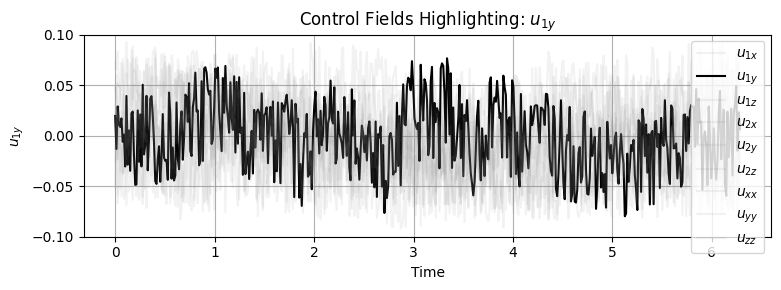

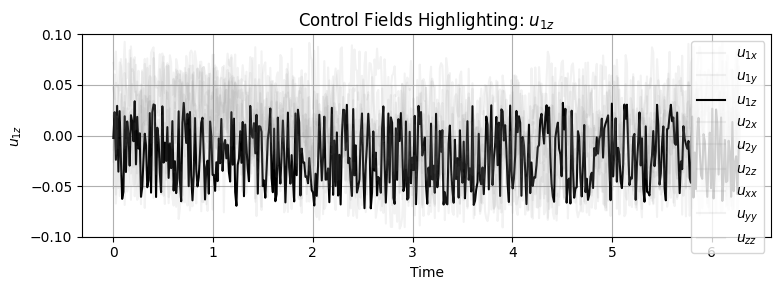

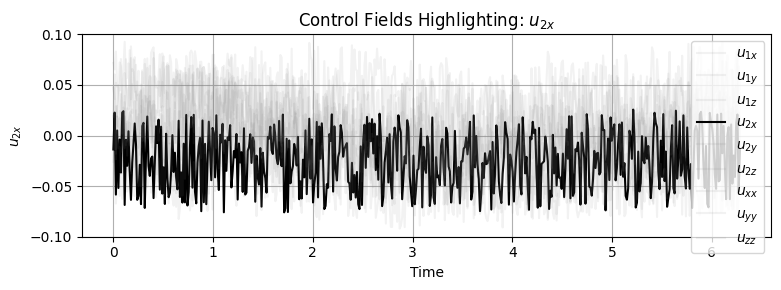

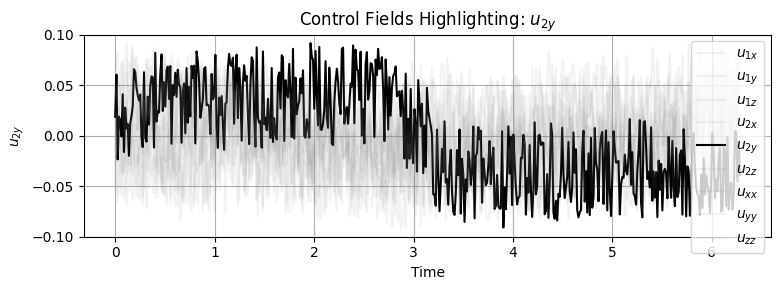

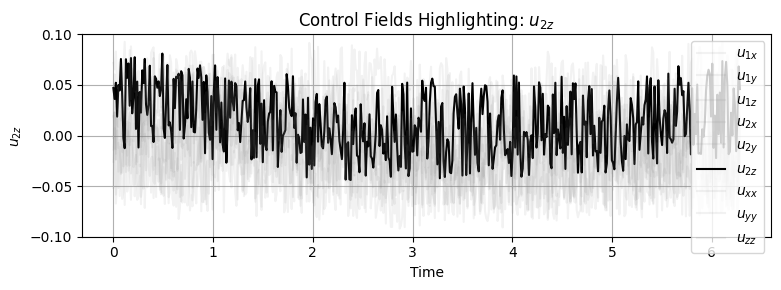

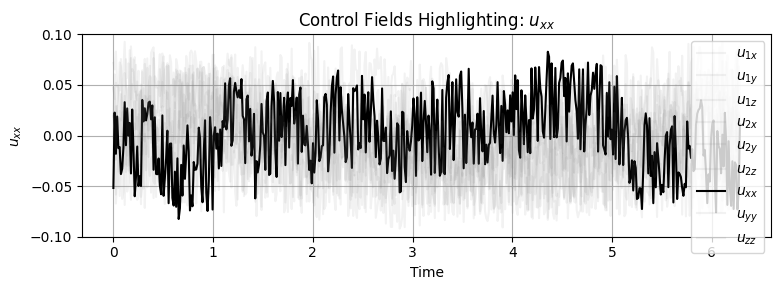

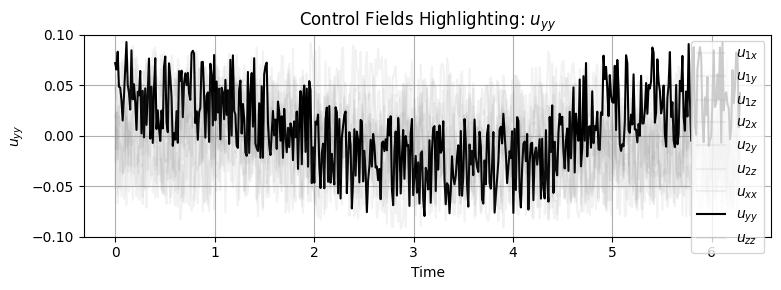

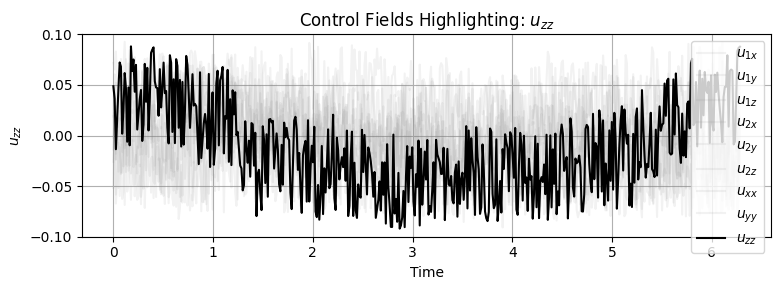

In [ ]:
import matplotlib.pyplot as plt


def plot_control_amplitudes(times, final_amps, labels):
    num_controls = final_amps.shape[1]

    y_max = 0.1  # Fixed y-axis scale
    y_min = -0.1

    for i in range(num_controls):
        fig, ax = plt.subplots(figsize=(8, 3))

        for j in range(num_controls):
            color = (
                'black' if i == j else 'gray'
            )  # Highlight the current control
            alpha = 1.0 if i == j else 0.1
            ax.plot(
                times,
                final_amps[:, j],
                label=labels[j],
                color=color,
                alpha=alpha,
            )
        ax.set_title(f"Control Fields Highlighting: {labels[i]}")
        ax.set_xlabel("Time")
        ax.set_ylabel(labels[i])
        ax.set_ylim(y_min, y_max)  # Set fixed y-axis limits
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()


times = jnp.linspace(0, 2 * jnp.pi, 500)
H_labels = [
    r'$u_{1x}$',
    r'$u_{1y}$',
    r'$u_{1z}$',
    r'$u_{2x}$',
    r'$u_{2y}$',
    r'$u_{2z}$',
    r'$u_{xx}$',
    r'$u_{yy}$',
    r'$u_{zz}$',
]
plot_control_amplitudes(
    times, result["control_amplitudes"] / (2 * jnp.pi), H_labels
)

In [3]:
U_target = cnot()
U_f = result["final_density_operator"]

In [4]:
def overlap(U_target, U_f):
    """
    Calculate the overlap between the target unitary U_target and the final unitary U_f.

    Parameters:
    U_target (qutip.Qobj): Target unitary operator.
    U_f (qutip.Qobj): Final unitary operator.

    Returns:
    float: Real part of the overlap value.
    float: Fidelity (absolute square of the overlap).
    """
    # dividing over U_target.shape[0] is for normalization
    overlap_value = (
        jnp.trace(jnp.matmul(U_target.conj().T, U_f)) / U_target.shape[0]
    )
    fidelity = abs(overlap_value) ** 2
    return overlap_value.real, fidelity


# Example usage
overlap_real, fidelity = overlap(U_target, U_f)
print(f"Overlap (real part): {overlap_real}")
print(f"Fidelity: {fidelity}")

Overlap (real part): 0.7070814371109009
Fidelity: 0.9999285936355591
